# Tutorial on iterative image denoising with Langevine dynamics.

In [ ]:
# Author: Róisín Luo
# Ref: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html

# Importing libraries

In [143]:
import sys
import os
import random
import math

import numpy as np


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib import patches
#from matplotlib.colors import to_rgb
#from mpl_toolkits.mplot3d.axes3d import Axes3D
#from mpl_toolkits.mplot3d import proj3d

from tqdm import tqdm

#import csv
#import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from PIL import Image

from atomicwrites import atomic_write #we must guarantee the automicity of write operation.
import pickle

%matplotlib inline

# Find GPU

In [144]:
def find_gpu():

    device = torch.device('cpu')
    
    if torch.cuda.is_available():
        print('# of CUDA devices: ', torch.cuda.device_count())
        
        for i in range(torch.cuda.device_count()):
            print()
            print(torch.cuda.get_device_name(i))
            print('CUDA memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,1), 'GB')
    
        device = torch.device('cuda')
        
    # MacOS
    elif hasattr(torch, "backends") and \
          hasattr(torch.backends, "mps") and \
          torch.backends.mps.is_available():
                
        device = torch.device('mps')
 
    print()
    print("Detected GPU device is: ", device)
    
    return device

In [145]:
device = find_gpu()
device


Detected GPU device is:  mps


device(type='mps')

# Load dataset

In [150]:
def plot_images(images, num_cols = 8, num_rows = 2):
    
    assert len(images) > num_cols * num_rows
    
    images = images[0: num_cols * num_rows]
    
    images = (images + 1) / 2

    #create grid with size by nrows x ncols
    img_grid = make_grid(tensor = images, 
                     nrow = num_cols, 
                     padding = 1, 
                     pad_value = 1)

    #conver to channel last
    img_grid = img_grid.permute(1,2,0)

    plt.figure(figsize=(16, 16))
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()   

In [151]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) #to [-1,+1]
                               ])

dataset = torchvision.datasets.MNIST(root="datasets", 
                                       train=True, 
                                       transform=transform, 
                                       download=True)


dataloader = torch.utils.data.DataLoader(dataset, 
                               batch_size=128, 
                               shuffle=True,  
                               #drop_last=True,  
                               #num_workers=4, 
                               #pin_memory=True
                            )

In [152]:
x,y = next(iter(dataloader))
x.shape

torch.Size([128, 1, 28, 28])

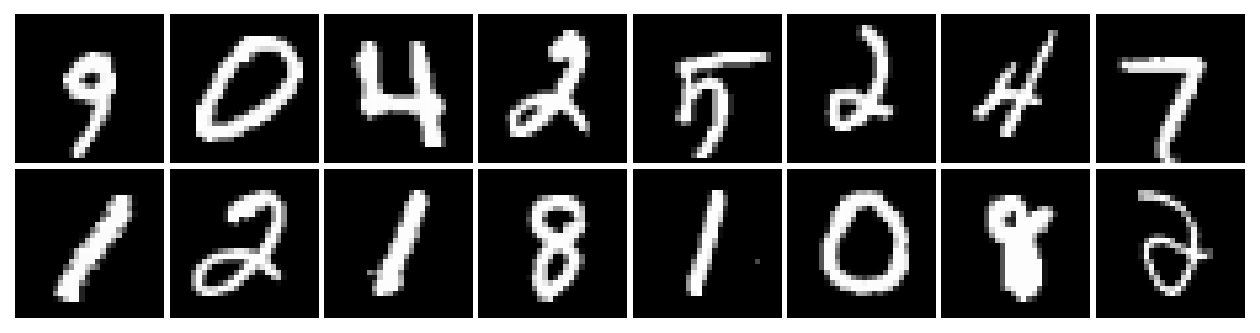

In [153]:
plot_images(x)

# Build energy model (simple)

In [154]:
#we hope the energy model is smooth.
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

#As standard practice/convention, the outputs represent the negative energy.
class EBMSimple(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=4),
            Swish(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            Swish(),
            
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            Swish(),
            
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            Swish(),
            
            nn.Flatten(),
            nn.Linear(128, 100),
            Swish(),
            
            nn.Linear(100, 1)
        )
    

    def forward(self, x):
        x = self.net(x)
        return x

In [155]:
model = EBMSimple()
print(model)

x = torch.rand(10, 1, 28, 28)
x = model(x)

print(x.shape)
print(x)

EBMSimple(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (1): Swish()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Swish()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Swish()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Swish()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=128, out_features=100, bias=True)
    (10): Swish()
    (11): Linear(in_features=100, out_features=1, bias=True)
  )
)
torch.Size([10, 1])
tensor([[0.0904],
        [0.0904],
        [0.0907],
        [0.0905],
        [0.0906],
        [0.0905],
        [0.0906],
        [0.0905],
        [0.0904],
        [0.0902]], grad_fn=<AddmmBackward0>)


# Build energy model (resnet based)

In [156]:
#we hope the energy model is smooth.
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

#As standard practice/convention, the outputs represent the negative energy.
class EBMResNet(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        self.decoder = torchvision.models.resnet18(pretrained = True)
        self.decoder.fc = nn.Identity()
        
        self.adapter = nn.Sequential(
            nn.Linear(512, 100),
            Swish(),
            
            nn.Linear(100, 1),
            
        )
    

    def forward(self, x):
        #self.decoder.eval()
        x = self.decoder(x)
        x = self.adapter(x)
        return x

In [9]:
#model = EBMResNet()
#x = torch.rand(10, 3, 32, 32)
#x = model(x)
#
#print(x.shape)

# Sampler for training and generating

In [157]:
class EBMSampler:
    def __init__(self, 
               #model,       #EBM
               image_size,  #image size
               sample_size, #sampling batch size.
               buffer_len = 8192):
        
        #self.model = model
        self.buffer_len = buffer_len
        self.image_size = image_size
        self.sample_size = sample_size
        self.sample_shape = (1,) + image_size
        
        self.buffer = [torch.rand((1, ) + image_size) * 2 - 1] * self.buffer_len
    
    #sample a batch for training.
    def train_sample(self, 
                   model,
                   num_new = None,
                   iters = 60, step_size = 10, device = torch.device("cpu")):
        
        if num_new is None:
            num_new = np.random.binomial(self.sample_size, 0.05)
        
        if num_new == 0:
            num_new = 1
        
        num_old = self.sample_size - num_new
                
        new_images = torch.rand((num_new,) + self.image_size) * 2 - 1
        
        old_images = random.choices(self.buffer, k = num_old)
        old_images = torch.cat(old_images, dim = 0)
        
        images = torch.cat([new_images, old_images], dim = 0)
        images = images.detach().to(device)
    
        # Perform MCMC sampling
        images = self.langevine_dynamics_sample(model,
                             images, 
                             iters = iters, 
                             step_size = step_size, 
                             device = device)

        self.buffer = list(images.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.buffer
        self.buffer = self.buffer[:self.buffer_len]
        
        return images
    
    #MCMC sampling with Langevine dynamics.
    def langevine_dynamics_sample(self, 
               model,
               images, 
               iters = 60, 
               step_size = 10, 
               return_images_per_step = False,
               device = torch.device("cpu")):
        
        model.to(device)
        images = images.to(device)
  
        images.requires_grad = True
        
        
        noise = torch.randn(images.shape, device = images.device)
        
        images_per_step = []

        
        for _ in range(iters):
      
            noise.normal_(0, 0.005)
            images.data.add_(noise.data)
            images.data.clamp_(min=-1.0, max=1.0)

            outputs = -model(images) 
            outputs = outputs.sum()
            
            #compute gradients wrt images.
            outputs.backward()
            
            #gradient clamp.
            images.grad.data.clamp_(-0.03, 0.03) 

            # Towards the direction with low-energy
            images.data.add_(-step_size * images.grad.data)
            
            images.grad.detach_()
            images.grad.zero_()
            images.data.clamp_(min=-1.0, max=1.0)

            if return_images_per_step:
                images_per_step.append(images.clone().detach())


        if return_images_per_step:
            return torch.stack(images_per_step, dim=0)
        else:
            return images

In [158]:
model = EBMSimple()
sampler = EBMSampler(image_size = (1, 28, 28), sample_size = 10)

model.eval()
for p in model.parameters():
    p.requires_grad = False
    
images = sampler.train_sample(model = model, device = device)
images.shape

torch.Size([10, 1, 28, 28])

# Training energy-based model for one epoch

In [159]:
%matplotlib inline

#from IPython.display import display, clear_output
from IPython import display

def EBM_train_one_epoch(
          model, 
          device, 
          dataloader, 
          optimizer, 
          epoch,
          sampler,
          sampler_iters = 60,
          sampler_step_size = 10,
          alpha = 0.2, #regularization weight.
          max_batches = None):
    
    # Enable gradient computing
    model.to(device)
    model.train()
    
    if max_batches is None:
        max_batches = len(dataloader)
        
    #averaged loss in current epoch.
    epoch_loss = 0.0
    total_loss_ = 0.0
    
    #contrastive divergence
    epoch_cdiv = 0.0
    total_cdiv_ = 0.0
    
    #regularization
    epoch_reg = 0.0
    total_reg_ = 0.0
    
    
    for batch_idx, batch in enumerate(dataloader, 1):
        
        real_images, _ = batch
        
        real_images = real_images.to(device)
      
        #simple data augmentation.
        noise = torch.randn_like(real_images) * 0.005
        #noise = torch.randn_like(real_images) * math.sqrt(eta)
        
        real_images.add_(noise).clamp_(min=-1.0, max=1.0)
        
        fake_images = sampler.train_sample(model = model,
                                         iters = sampler_iters, 
                                         step_size = sampler_step_size, 
                                         device = device)

        images = torch.cat([real_images, fake_images], dim = 0)

        optimizer.zero_grad()

        #model outputs negative energy.
        outputs = -model(images)
        
        real_outputs, fake_outputs = outputs.chunk(2, dim = 0)
        
        #computing batch loss.
        
        #we hope the minimum energy close to zero.
        batch_reg = alpha * (real_outputs**2 + fake_outputs**2).mean()        
        batch_cdiv = real_outputs.mean() - fake_outputs.mean()
        batch_loss = batch_reg + batch_cdiv
        
        #computing gradients
        batch_loss.backward()

        #update weights.
        optimizer.step()
        
        #update statistics
        total_reg_ += batch_reg
        total_cdiv_ += batch_cdiv
        total_loss_ += batch_loss
        
        epoch_reg = total_reg_ / batch_idx
        epoch_cdiv = total_cdiv_ / batch_idx
        epoch_loss = total_loss_ / batch_idx
        
        
        #Updating training displays.
        display.clear_output(wait=True)
        
        display.display('Epoch {} [{}/{} ({:.0f}%)]'.format(
                    epoch, batch_idx, 
                    len(dataloader), 
                    100. * (batch_idx / len(dataloader))))
        
        display.display('* regularization batch {:.6f} epoch {:.6f}'.format(
                    batch_reg, epoch_reg))
        
        display.display('* contrastive divergence batch {:.6f} epoch {:.6f}'.format(
                    batch_cdiv, epoch_cdiv))
        
        display.display('* loss batch {:.6f} epoch {:.6f}'.format(
                    batch_loss, epoch_loss))
        
        if batch_idx > max_batches:
            break
    
    return epoch_reg, epoch_cdiv, epoch_loss

In [160]:
device = find_gpu()
print(device)


Detected GPU device is:  mps
mps


In [161]:
batch_size = 128
model = EBMSimple()
sampler = EBMSampler(image_size = (1, 28, 28), sample_size = batch_size)

In [162]:
dataloader = torch.utils.data.DataLoader(dataset, 
                               batch_size=batch_size, 
                               shuffle=True,  
                               #drop_last=True,  
                               #num_workers=4, 
                               #pin_memory=True
                            )

In [163]:
#for Adam the learning rate 
#typically less than 0.001 for stabability.
learning_rate = 0.001


optimizer = torch.optim.Adam(
                        model.parameters(), 
                        lr = learning_rate,
                        betas = (0.99, 0.999),
                        #momentum = 0.9, 
                        #weight_decay = 5e-4
                      )

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs

In [61]:
epoch_reg, epoch_cdiv, epoch_loss = EBM_train_one_epoch(
          model, 
          device, 
          dataloader, 
          optimizer, 
          epoch = 1,
          sampler = sampler,
          sampler_iters = 60,
          sampler_step_size = 10,
          alpha = 0.2, 
          max_batches = None)

'Epoch 1 [469/469 (100%)]'

'* regularization batch 0.000214 epoch 0.012221'

'* contrastive divergence batch 0.010302 epoch -0.016724'

'* loss batch 0.010516 epoch -0.004503'

# Save and load model from disk

In [164]:
import os

def save_model(model, model_path):
    
    save_path = os.path.normpath(os.path.dirname(model_path)).rstrip(os.path.sep)
        
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    print("Save model weights to: ", model_path)
    torch.save(model.state_dict(), model_path)  

In [165]:
save_model(model, "models/ebm_simple.pth")

Save model weights to:  models/ebm_simple.pth


In [166]:
def load_model(model_path, device):
    model = EBMSimple()
    
    if os.path.exists(model_path):
        #re-loading
        model.load_state_dict(torch.load(model_path, map_location = device)) 
        print("Loaded model weights from: ", model_path)
    else:
        print("Model weights not found.")
        
    return model

In [167]:
model = load_model("models/ebm_simple.pth", device)

Loaded model weights from:  models/ebm_simple.pth


# Generate samples

In [168]:
def generate_samples(model, 
                     sampler,
                     iters = 60,
                     step_size = 10,
                     num_samples = 16, 
                     image_size = (1, 28, 28),
                     device = torch.device("cpu")):
    model.eval()
    model.to(device)

    for p in model.parameters():
        p.requires_grad = False

    
    images = torch.rand((16,) + image_size) * 2 - 1

    images = sampler.langevine_dynamics_sample( 
               model,
               images, 
               iters = iters, 
               step_size = step_size, 
               return_images_per_step = False,
               device = device)

    for p in model.parameters():
        p.requires_grad = True
        
    images = images.cpu().detach()
    #images.shape
    
    #visualize
    images = images[0:16]

    images = (images + 1) / 2

    #create grid with size by nrows x ncols
    img_grid = make_grid(tensor = images, 
                     nrow = 8, 
                     padding = 1, 
                     pad_value = 1)

    #conver to channel last
    img_grid = img_grid.permute(1,2,0)

    plt.figure(figsize=(16, 16))
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()   

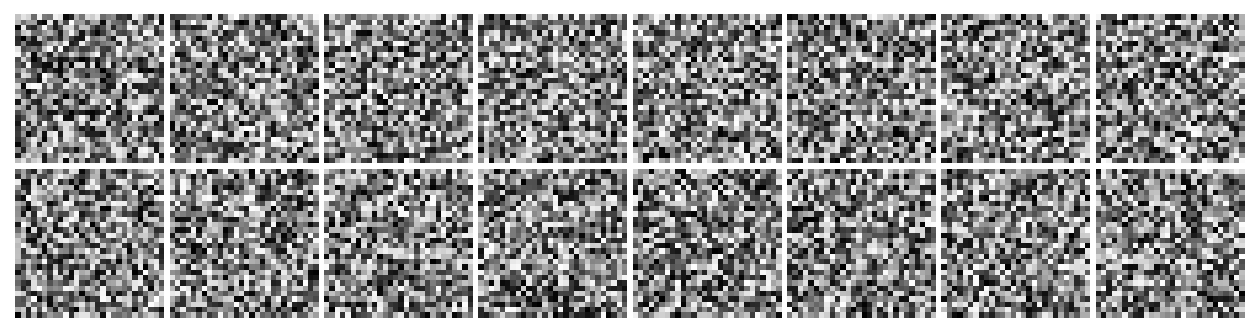

In [169]:
generate_samples(model, 
                 sampler,
                 iters = 50,
                 step_size = 10,
                 num_samples = 16, 
                 image_size = (1, 28, 28),
                 device = device)

# Complete training

In [75]:
def EBM_train(model, 
          device, 
          dataloader, 
          optimizer,
          epochs,
          sampler,
          sampler_iters = 60,
          sampler_step_size = 10,
          alpha = 0.2, #regularization weight.
          scheduler = None,
          max_batches = None):
    
    #if model_path is not None and not os.path.exists(model_path):
    #    os.makedirs(model_path)
    
    loss_hist = []    
    reg_hist = []
    cdiv_hist = []
    
    for epoch in range(1, epochs + 1):
        
        epoch_reg, epoch_cdiv, epoch_loss = EBM_train_one_epoch(
          model = model, 
          device = device, 
          dataloader = dataloader, 
          optimizer = optimizer, 
          epoch = epoch,
          sampler = sampler,
          sampler_iters = sampler_iters,
          sampler_step_size = sampler_step_size,
          alpha = alpha, 
          max_batches = max_batches)
    
        if scheduler:
            #adjusting LR is necessary
            scheduler.step()
            
        loss_hist.append(epoch_loss)
        reg_hist.append(epoch_reg)
        cdiv_hist.append(epoch_cdiv)
           
    return reg_hist, cdiv_hist, loss_hist

In [81]:
reg_hist, cdiv_hist, loss_hist = EBM_train(model, 
          device, 
          dataloader, 
          optimizer,
          epochs = 20,
          sampler = sampler,
          sampler_iters = 60,
          sampler_step_size = 10,
          alpha = 0.2, 
          scheduler = scheduler,
          max_batches = None)

'Epoch 2 [127/469 (27%)]'

'* regularization batch 0.000421 epoch 0.000440'

'* contrastive divergence batch 0.020891 epoch 0.023432'

'* loss batch 0.021313 epoch 0.023872'

KeyboardInterrupt: 

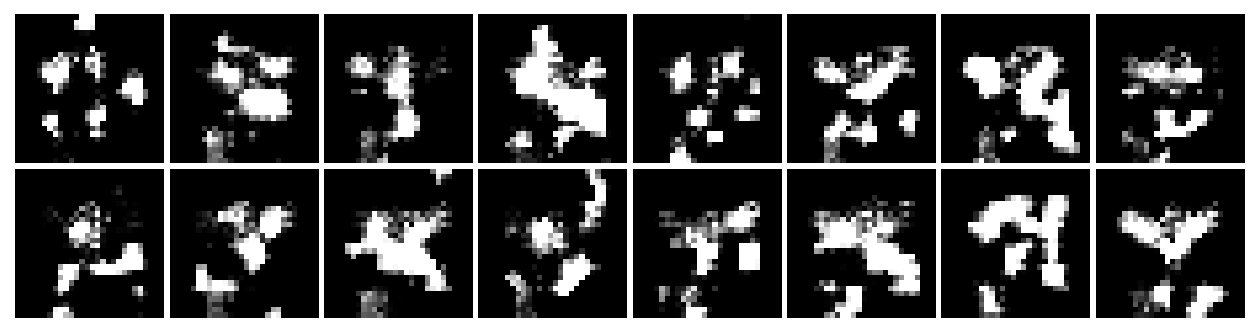

In [105]:
generate_samples(model, 
                 sampler,
                 iters = 80,
                 step_size = 100,
                 num_samples = 16, 
                 image_size = (1, 28, 28),
                 device = device)

# Image denoising with Langevine dynamics equation

In [106]:
def denoise_samples(model, 
                    images,
                    sampler,
                    iters = 60,
                    step_size = 10,
                    num_samples = 16, 
                    image_size = (1, 28, 28),
                    device = torch.device("cpu")):
    model.eval()
    model.to(device)

    for p in model.parameters():
        p.requires_grad = False

    
    images = sampler.langevine_dynamics_sample( 
               model,
               images, 
               iters = iters, 
               step_size = step_size, 
               return_images_per_step = False,
               device = device)

    for p in model.parameters():
        p.requires_grad = True
        
    images = images.cpu().detach()
    #images.shape
    
    #visualize
    images = images[0:16]

    images = (images + 1) / 2

    #create grid with size by nrows x ncols
    img_grid = make_grid(tensor = images, 
                     nrow = 8, 
                     padding = 1, 
                     pad_value = 1)

    #conver to channel last
    img_grid = img_grid.permute(1,2,0)

    plt.figure(figsize=(16, 16))
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()   

In [131]:
images, _ = next(iter(dataloader))
images = images[0:16]
images.shape

torch.Size([16, 1, 28, 28])

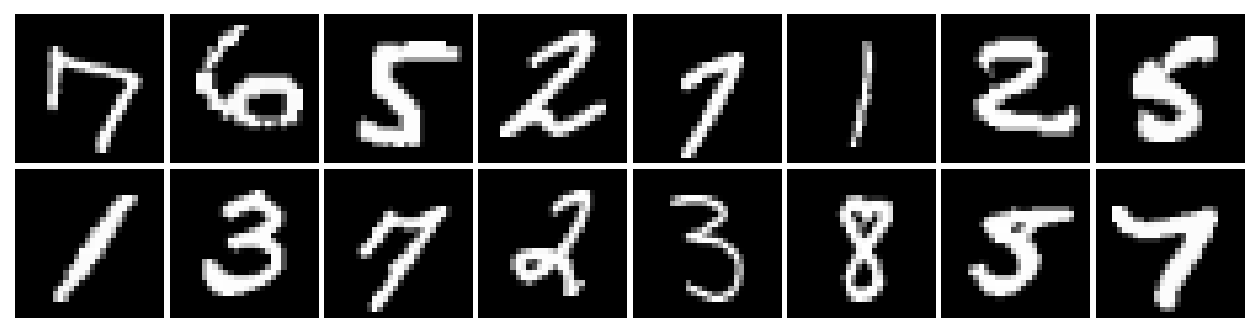

In [133]:
plot_images(images)

In [140]:
noise = torch.zeros_like(images)
noise.normal_(0, 1)
#noise = torch.rand(images.size())
noise = torch.randn(images.size())
images.data.add_(noise.data)
#noise_images = images + noise
noise_images = images.data.clamp_(min=-1.0, max=1.0)
noise_images.shape

torch.Size([16, 1, 28, 28])

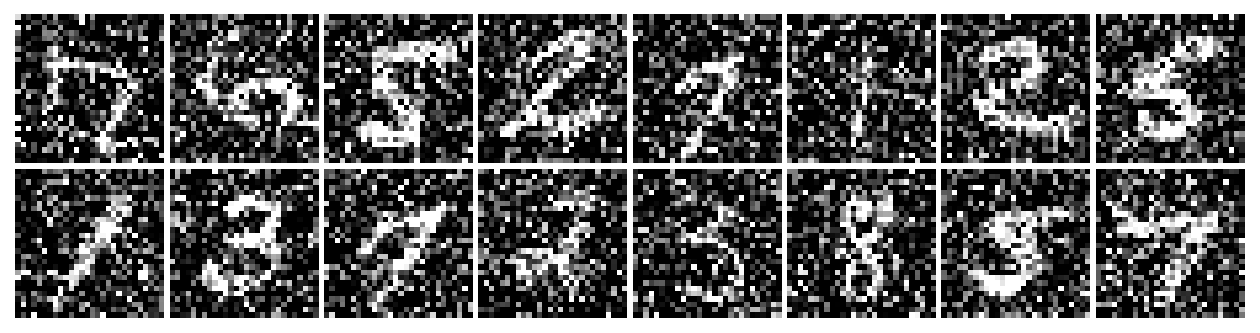

In [141]:
plot_images(noise_images)

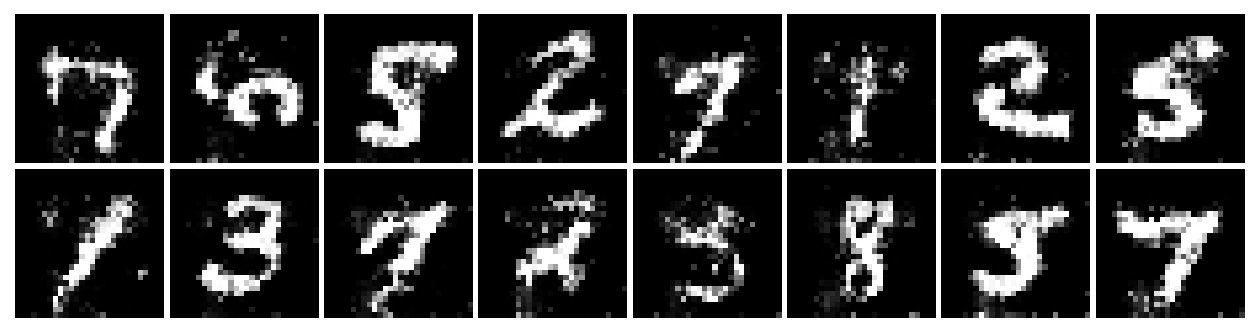

In [142]:
denoise_samples(model, 
                noise_images,
                sampler,
                    iters = 200,
                    step_size = 10,
                    num_samples = 16, 
                    image_size = (1, 28, 28),
                    device = device)